# GEPA for JEE (Math)
Using the `dspy.GEPA` optimizer, we compare the performances of Gemma 27b It and OpenAI OSS 20b on Math questions from JEE, before and after GEPA optmization.

In [ ]:
# api_key = input("Enter your OpenAI API key: ")
import dspy
import re

api_key = ""
gemini_api_key = ""

gemma = "openrouter/google/gemma-3-27b-it"
qwen = "openrouter/qwen/qwen3-32b"
openai_oss = "openai/gpt-oss-20b"

      
extraction_lm = dspy.LM(
    model="openrouter/openai/gpt-4o-mini", 
    api_base="https://openrouter.ai/api/v1",
    api_key=api_key, 
    temperature=0.1, 
    max_tokens=32000
)

from dspy.adapters import TwoStepAdapter
adapter = dspy.adapters.TwoStepAdapter(extraction_lm)

lm = dspy.LM(
    model=gemma,
    api_base="https://openrouter.ai/api/v1",
    api_key=api_key,
    temperature=1,
    max_tokens=32000,
)

dspy.configure(lm=lm, adapter=adapter)

In [13]:
import dspy

# Define a signature for feedback
class FeedbackSignature(dspy.Signature):
    """Give feedback on an incorrect solution to a math problem. It might be incorrect due to the reasoning or the answer formatting,
    solution must be inside \boxed{}. solution must follow this format: problem = dspy.InputField()
    answer = dspy.OutputField()
    """
    question: str = dspy.InputField()
    solution: str = dspy.InputField()
    expected_answer: str = dspy.InputField()
    feedback: str = dspy.OutputField(desc="Constructive feedback about the solution")

gemini_lm = dspy.LM(
    model="gemini-2.5-flash-lite",
    temperature=1.0,
    max_tokens=32000,
    api_key=gemini_api_key
)

# Function to get feedback
def get_llm_feedback(question, solution, expected_answer):
    # Create the feedback module
    feedback_module = dspy.ChainOfThought(
        FeedbackSignature,
        lm=gemini_lm
    )
    
    with dspy.context(lm=gemini_lm):
        # Call the LLM with structured inputs
        result = feedback_module(
            question=question,
            solution=solution,
            expected_answer=expected_answer
    )
        
    print("Feedback:", result.feedback[:100])
    
    return result.feedback


In [14]:
!pip install google-auth


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [15]:
get_llm_feedback("How much is 2 + 2?", "The answer is 4.", "4")  # Example usage

Feedback: The solution is correct and follows the expected format. No changes are needed.


'The solution is correct and follows the expected format. No changes are needed.'

In [16]:
math = dspy.ChainOfThought("question -> answer: float")
math(question="Two dice are tossed. What is the probability that the sum equals 2?")

Prediction(
    reasoning='When two dice are tossed, the sample space consists of 36 possible outcomes, since each die has 6 faces. We want to find the probability that the sum of the two dice equals 2. The only way to get a sum of 2 is if both dice show a 1. This corresponds to the outcome (1, 1). Therefore, there is only 1 favorable outcome. The probability of an event is calculated as the number of favorable outcomes divided by the total number of possible outcomes. In this case, the probability is 1/36.',
    answer=0.027777777777777776
)

### Loading the JEE dataset

In [17]:
import dspy
from datasets import load_dataset

def init_jee_dataset():
    dataset = load_dataset("PhysicsWallahAI/JEE-Main-2025-Math", "apr")['test']

    # Split the dataset
    split = dataset.train_test_split(test_size=0.25, seed=42)
    train_set_2025 = split['train']
    test_set_2025 = split['test'].select(range(int(0.5 * len(split['test']))))
    val_set_2025 = split['test'].select(range(int(0.5 * len(split['test'])), len(split['test'])))

    # Convert to dspy.Example format
    train_set = [
        dspy.Example({
            "problem": x['question'],
            "answer": x['answer'],
        }).with_inputs("problem")
        for x in train_set_2025
    ]

    val_set = [
        dspy.Example({
            "problem": x['question'],
            "answer": x['answer'],
        }).with_inputs("problem")
        for x in val_set_2025
    ]

    test_set = [
        dspy.Example({
            "problem": x['question'],
            "answer": x['answer'],
        }).with_inputs("problem")
        for x in test_set_2025
    ]

    return train_set, val_set, test_set

# Example usage
train, val, test = init_jee_dataset()
print("Train size:", len(train))
print("Val size:", len(val))
print("Test size:", len(test))


Train size: 168
Val size: 29
Test size: 28


### Defining the program: `dspy.ChainOfThought`

In [18]:
class GenerateResponse(dspy.Signature):
    """Solve the problem and provide the answer in the correct format."""
    problem = dspy.InputField()
    answer = dspy.OutputField()

program = dspy.ChainOfThought(GenerateResponse)
program_openai = dspy.ChainOfThought(GenerateResponse)

### Defining the evaluation metric
We simply check exact match between the predicted answer and the correct answer.

In [19]:
def metric(example, prediction, trace=None, pred_name=None, pred_trace=None):
    correct_answer = str(example['answer'])
    try:
        llm_answer = str(prediction.answer)
    except ValueError as e:
        return 0
    return int(correct_answer == llm_answer)

### Optimize the program with `dspy.GEPA`

In [20]:
#Experimental: adding a LLm-as-judge to provide feedback
def metric_with_feedback_llm(example, prediction, trace=None, pred_name=None, pred_trace=None):
    correct_answer = str(example['answer'])
    written_solution = example.get('solution', '')
    try:
        llm_answer = str(prediction.answer)
    except ValueError as e:
        print(f"Couldn't parse answer as integer: {prediction.answer}")
        feedback_text = f"The final answer must be a valid integer and nothing else. You responded with '{prediction.answer}', which couldn't be parsed as a python integer. Please ensure your answer is a valid integer without any additional text or formatting."
        #feedback_text += f" The correct answer is '{correct_answer}'."
        if written_solution:
        #    feedback_text += f" Here's the full step-by-step solution:\n{written_solution}\n\nThink about what takeaways you can learn from this solution to improve your future answers and approach to similar problems and ensure your final answer is a valid integer."
            feedback_text += get_llm_feedback(example['problem'], written_solution, str(correct_answer))
        return dspy.Prediction(score=0, feedback=feedback_text)

    score = int(correct_answer == llm_answer)

    feedback_text = get_llm_feedback(example['problem'], written_solution, str(correct_answer))
    # feedback_text = ""
    # if score == 1:
    #     feedback_text = f"Your answer is correct. The correct answer is '{correct_answer}'."
    # else:
    #     feedback_text = f"Your answer is incorrect. The correct answer is '{correct_answer}'."
    
    # if written_solution:
    #     feedback_text += f" Here's the full step-by-step solution:\n{written_solution}\n\nThink about what takeaways you can learn from this solution to improve your future answers and approach to similar problems."

    return dspy.Prediction(score=score, feedback=feedback_text)

In [21]:
def metric_with_feedback(example, prediction, trace=None, pred_name=None, pred_trace=None):
    
    correct_answer = str(example['answer'])
    written_solution = example.get('solution', '')
    try:
        llm_answer = str(prediction.answer)
    except ValueError as e:
        feedback_text = f"The final answer must be a valid integer and nothing else. You responded with '{prediction.answer}', which couldn't be parsed as a python integer. Please ensure your answer is a valid integer without any additional text or formatting."
        feedback_text += f" The correct answer is '{correct_answer}'."
        if written_solution:
            feedback_text += f" Here's the full step-by-step solution:\n{written_solution}\n\nThink about what takeaways you can learn from this solution to improve your future answers and approach to similar problems and ensure your final answer is a valid integer."
        return dspy.Prediction(score=0, feedback=feedback_text)
    
    if llm_answer is None:
        feedback_text = f"The final answer must be a valid integer and nothing else. You responded with '{prediction.answer}', which couldn't be parsed as a python integer. Please ensure your answer is a valid integer without any additional text or formatting."
        feedback_text += f" The correct answer is '{correct_answer}'."
        if written_solution:
            feedback_text += f" Here's the full step-by-step solution:\n{written_solution}\n\nThink about what takeaways you can learn from this solution to improve your future answers and approach to similar problems and ensure your final answer is a valid integer."
        return dspy.Prediction(score=0, feedback=feedback_text)

    score = int(correct_answer == llm_answer)

    # if not score and pred_name is not None:
    #     print("Calling the llm feedback function!")
    #     return metric_with_feedback_llm(example, prediction, trace, pred_name, pred_trace)
    # else:
    feedback_text = ""
    if score == 1:
        feedback_text = f"Your answer is correct. The correct answer is '{correct_answer}'."
    else:
        feedback_text = f"Your answer is incorrect. The correct answer is '{correct_answer}'."
    
    if written_solution:
        feedback_text += f" Here's the full step-by-step solution:\n{written_solution}\n\nThink about what takeaways you can learn from this solution to improve your future answers and approach to similar problems."

    return dspy.Prediction(score=score, feedback=feedback_text)

In [22]:
from dspy import GEPA

optimizer = GEPA(
    metric=metric_with_feedback,
    auto="light",
    #max_full_evals=2,
    num_threads=32,
    track_stats=True,
    reflection_minibatch_size=5,
    reflection_lm=dspy.LM(model="gemini-2.5-pro", temperature=1.0, max_tokens=32000, api_key=gemini_api_key)
)

optimized_program = optimizer.compile(
    program,
    trainset=train,
    valset=val,
)

2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Running GEPA for approx 496 metric calls of the program. This amounts to 2.52 full evals on the train+val set.
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Using 29 examples for tracking Pareto scores. You can consider using a smaller sample of the valset to allow GEPA to explore more diverse solutions within the same budget.
2025/08/20 22:23:08 INFO dspy.evaluate.evaluate: Average Metric: 13.0 / 29 (44.8%)
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 0: Base program full valset score: 0.4482758620689655
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Selected program 0 score: 0.4482758620689655


Average Metric: 4.00 / 5 (80.0%): 100%|██████████| 5/5 [00:00<00:00, 493.05it/s] 

2025/08/20 22:23:08 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Proposed new text for predict: You are a math problem-solving assistant. Your goal is to accurately solve the provided mathematical problem and present the solution in a specific two-part format.

**Task Instructions:**

1.  **Solve the Problem:** Carefully read the problem, identify the key mathematical concepts involved (e.g., calculus, algebra, probability, number theory), and determine the correct method to find the solution.
2.  **Format the Output:** Your response must contain exactly two sections, in this order:
    *   `### reasoning`
    *   `### answer`

**Section Details:**

1.  **`### reasoning`**:
    *   In this section, provide a clear explanation of your problem-solving process.
    *   You can either give a high-level summary of your approach or a detailed, step-by-step derivation.
    *   Mention the key mathematical princip

2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 1: New program candidate index: 1
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: No merge candidates found
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Selected program 1 score: 0.41379310344827586


Average Metric: 1.00 / 5 (20.0%): 100%|██████████| 5/5 [00:00<00:00, 61.28it/s]

2025/08/20 22:23:08 INFO dspy.evaluate.evaluate: Average Metric: 1.0 / 5 (20.0%)
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   Read the problem meticulously. Identify the mathematical domain (e.g., calculus, trigonometry, algebra, probability, geometry).
    *   Select the most effective strategy. Think step-by-step and be extremely careful with algebraic manipulations, substitutions, and applying formulas.
    *   **Double-check your work for common pitfalls.** For example:
        *   **Trigonometry:** Remember that `sqrt(x^2) = |x|`. Be mindful of the signs of trigonometric functions in different quadrants (e.g., `cos(2)` is negative since 2 radians is in the second quadrant). Pay clo

2025/08/20 22:23:08 INFO dspy.evaluate.evaluate: Average Metric: 14.0 / 29 (48.3%)
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: New program is on the linear pareto front
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Full valset score for new program: 0.4827586206896552
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Full train_val score for new program: 0.4827586206896552
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Individual valset scores for new program: [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: New valset pareto front scores: [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Full valset pareto front score: 0.5172413793103449
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Updated 

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 485.31it/s]

2025/08/20 22:23:08 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:08 INFO dspy.teleprompt.gepa.gepa: Iteration 3: Proposed new text for predict: You are an expert-level math problem-solving assistant. Your primary goal is to accurately solve challenging mathematical problems and present the solution in a specific, structured, two-part format.

**Task Instructions:**

1.  **Solve the Problem:**
    *   Thoroughly analyze the problem statement.
    *   Identify the relevant mathematical domain(s) (e.g., Calculus, Linear Algebra, Vector Geometry).
    *   Select and apply the correct theorems, formulas, and techniques to derive the solution.
    *   Double-check your calculations and logical steps to ensure accuracy.

2.  **Format the Output:**
    *   Your response must be divided into exactly two sections, in the following order:
        *   `### reasoning`
        *   `### answer`
    *   Do not include any other text or formatting before, between, or af


Average Metric: 0.00 / 5 (0.0%): 100%|██████████| 5/5 [00:00<00:00, 573.40it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 5 (0.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 4: Proposed new text for predict: You are a high-precision math problem-solving assistant. Your goal is to solve the provided mathematical problem with exceptional accuracy and present the solution in a very specific format. Scrutinize every step of your reasoning and calculation, as errors are often subtle.

**Task Instructions:**

1.  **Solve the Problem:**
    *   **Analyze Carefully:** Read the problem statement multiple times. Identify the key variables, their domains (e.g., real vs. complex numbers), and the exact quantity to be found. Pay close attention to subtle wording. For instance, "roots" may include complex roots unless specified as "real roots." If a variable's domain like `x` is ambiguous, state your assumption (e.g., "Assuming x is a real variable...").
    *   **Select the Correct Method:** Identify the relevant mathematical fie


Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 561.37it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and to present the solution clearly in a specific two-part format.

**Problem-Solving Strategy:**

To ensure accuracy, you must follow a methodical, four-step process:

1.  **Deconstruct the Problem:**
    *   Carefully read the problem statement.
    *   Identify all given quantities, variables, and constraints.
    *   Determine the specific question being asked and the mathematical concepts involved (e.g., 3D Geometry, Conic Sections, Calculus, Trigonometry).

2.  **Formulate a Plan:**
    *   Choose the most appropriate theorems, formulas, and techniques.
    *   **For 3D Geometry:** Use vector parameterizations for lines (`P = P_0 + t * d`), the dot product to check for perpendic


Average Metric: 0.00 / 5 (0.0%): 100%|██████████| 5/5 [00:00<00:00, 630.12it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 5 (0.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 6: Proposed new text for predict: You are an expert-level math problem-solving assistant. Your primary goal is to accurately solve the provided mathematical problem and present the solution in a specific, strictly-enforced two-part format.

**Task Instructions:**

1.  **Analyze and Solve the Problem:**
    *   Carefully read the problem to understand the question and the given information.
    *   Identify the key mathematical concepts involved (e.g., calculus, coordinate geometry, complex numbers, algebra).
    *   Determine and apply the correct methods, formulas, and theorems to derive the solution. Pay close attention to details to avoid factual errors.
    *   If a problem statement appears incomplete (e.g., it asks to find variables `α` and `β` but ends with "...then"), you should infer the most probable final quantity required, such as `α 


Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 646.59it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 7: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   Read the problem meticulously. Identify the mathematical domain (e.g., calculus, linear algebra, set theory, geometry).
    *   Formulate a clear, step-by-step strategy. Before writing the final reasoning, think through the problem to find the most efficient and robust path.
    *   **For combinatorial or counting problems**, use a systematic approach. Start with the minimal set of elements required by the constraints (e.g., for a reflexive relation, include all `(a,a)` pairs). Then, systematically build upon this set by considering all possible additions, checking at each step that all conditions (like transitivity or size limits) are met. E

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 573.01it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 8: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   Read the problem meticulously. Identify the mathematical domain (e.g., calculus, trigonometry, algebra, vector algebra, geometry).
    *   Select the most effective strategy. Think step-by-step and be extremely careful with algebraic manipulations, substitutions, and applying formulas.
    *   **Verify the final objective.** After finding an intermediate result (e.g., the area of a triangle, the value of a common ratio), re-read the problem's final sentence. Ensure your answer corresponds to the exact quantity the problem asks for. For instance, if the problem st


Average Metric: 1.00 / 5 (20.0%): 100%|██████████| 5/5 [00:00<00:00, 656.18it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 1.0 / 5 (20.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with complete accuracy. Your secondary goal is to present your solution in a strict, specific format.

**Task Instructions:**

1.  **Solve the Problem:** First, meticulously analyze the problem to understand what is being asked. Identify the relevant mathematical domain (e.g., calculus, number theory, coordinate geometry) and devise a correct, step-by-step plan to reach the solution. Accuracy is paramount.

2.  **Format the Output:** Your entire response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   In this section, you must provide a clear and logical explanation of your problem-solving 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 13.0 / 29 (44.8%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Full valset score for new program: 0.4482758620689655
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Full train_val score for new program: 0.4482758620689655
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Individual valset scores for new program: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: New valset pareto front scores: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Full valset pareto front score: 0.5517241379310345
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Updated valset pareto front programs: [{0, 1, 2, 3}, {0, 1, 2, 3}, {3}, {0, 1, 2, 3}, {0, 1, 2, 3}, {0, 1, 2, 3}, {

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 413.53it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 10: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   Read the problem meticulously. Identify the mathematical domain (e.g., calculus, vectors, analytic geometry, algebra).
    *   Select the most effective strategy. Look for elegant solutions, shortcuts, or applicable theorems *before* starting brute-force calculations. Think step-by-step and be extremely careful with algebraic manipulations.
    *   **Double-check your work for common pitfalls and apply domain-specific strategies:**
        *   **Problem Interpretation:** Some problems may contain multiple parts. If you solve for variables (e.g., `a`, `b`) in the first part, they are almost certainly required for the second part. If the secon

Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 574.97it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 11: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   Read the problem meticulously. Identify the mathematical domain (e.g., calculus, trigonometry, algebra, probability, geometry).
    *   Select the most effective strategy. Think step-by-step. Be extremely careful with algebraic manipulations, substitutions, and applying formulas.
    *   **Double-check your work for common pitfalls and apply domain-specific strategies.**

    **Domain-Specific Strategies & Checklists:**
    *   **Infinite Series:**
        *   If the general term involves fractions of polynomials, try to simplify it.
        *   For series invol

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 1.0 / 5 (20.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 11: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 12: Selected program 1 score: 0.41379310344827586


Average Metric: 4.00 / 5 (80.0%): 100%|██████████| 5/5 [00:00<00:00, 554.57it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 12: Proposed new text for predict: You are an expert math problem-solving assistant. Your goal is to accurately solve the provided mathematical problem and present the solution in a specific, structured, two-part format.

**Task Instructions:**

1.  **Analyze and Strategize:**
    *   Carefully read the problem to understand the question and the given conditions.
    *   Identify the key mathematical concepts involved (e.g., calculus, coordinate geometry, combinatorics, binomial theorem).
    *   Formulate a high-level strategy before diving into calculations. For example, decide if L'Hopital's Rule or Taylor Series is more appropriate for a limit, or if casework is needed for a counting problem.

2.  **Solve the Problem:**
    *   Execute your strategy, showing the logical steps in your reasoning.
    *   Be flexible. If one method becomes over

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 12: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 13: Selected program 3 score: 0.4482758620689655


Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 520.29it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 13: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with complete accuracy. Your secondary goal is to present your solution in a strict, specific format.

**Task Instructions:**

1.  **Solve the Problem:** First, meticulously analyze the problem to understand what is being asked. Identify the relevant mathematical domain and devise a correct, step-by-step plan to reach the solution. Accuracy is paramount.

2.  **Format the Output:** Your entire response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   Provide a rigorous, step-by-step derivation of the solution. Show your complete thought process, starting from the given information and progr

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 13: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 14: Selected program 1 score: 0.41379310344827586


Average Metric: 1.00 / 5 (20.0%): 100%|██████████| 5/5 [00:00<00:00, 549.64it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 1.0 / 5 (20.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 14: Proposed new text for predict: You are an expert-level math problem-solving assistant. Your primary goal is to solve the provided mathematical problem with exceptional accuracy and present the solution in a specific, structured format.

**Task Instructions:**

1.  **Solve the Problem:**
    *   Read the problem statement meticulously. Identify the core mathematical domain (e.g., calculus, algebra, coordinate geometry, number theory).
    *   Devise a robust strategy. Before beginning calculations, consider the most efficient and least error-prone method.
    *   Execute the solution steps logically and double-check all calculations.

2.  **Format the Output:**
    *   Your response must consist of exactly two sections, in this precise order:
        *   `### reasoning`
        *   `### answer`
    *   Do not include any other text or headers.

**Section Details:**

1.  **`### reasoning`**:
    *   Provide a clear and com

Average Metric: 4.00 / 5 (80.0%): 100%|██████████| 5/5 [00:00<00:00, 413.22it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 15: Proposed new text for predict: You are an expert-level math problem-solving assistant. Your sole purpose is to solve a given mathematical problem and present the solution in a specific, two-part format. Your work will be judged on its absolute accuracy and strict adherence to the formatting guidelines.

**Primary Directive:** Solve the problem correctly. There is no partial credit for incorrect answers.
**Secondary Directive:** Format the output perfectly according to the rules below.

---

### **Task Instructions**

1.  **Analyze and Solve:**
    *   Begin by meticulously deconstructing the problem to understand all its conditions and what is being asked.
    *   Identify the relevant mathematical concepts, formulas, and theorems (e.g., quadratic formula, binomial theorem, properties of arithmetic progressions, formulas for mean and variance, distance from a point to a line, methods for solving differential equations).


Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 628.87it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 16: Proposed new text for predict: You are an expert-level math problem-solving assistant. Your primary goal is to solve the given mathematical problem with impeccable accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   **Meticulous Analysis:** Read the problem with extreme care. Identify the mathematical domain (e.g., complex numbers, linear algebra, trigonometry, set theory). Pinpoint all given information, constraints, and the exact quantity or statement to be found.
    *   **Strategic Planning:** Before calculating, devise a strategy. Look for elegant shortcuts, symmetries, or theorems that can simplify the problem. For instance, simplifying an expression algebraically *before* substituting values is often less error-prone.
    *   **Careful Execution:** Perform all calculations, algebraic manipulations, and logical deductions step-by-step.

Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 533.84it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 17: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to provide a meticulously correct and clearly explained solution to a given mathematical problem. The solution must follow a specific two-part format.

**Task Instructions:**

1.  **Analyze and Strategize:**
    *   Read the problem statement with extreme care. Identify all given information, constraints, and the exact question being asked.
    *   Recognize the key mathematical domains involved (e.g., Calculus, Algebra, Conic Sections, Trigonometry, Number Theory).
    *   Formulate a clear, logical strategy for solving the problem. Before you start calculating, think about the most efficient path to the solution.

2.  **Execute and Derive:**
    *   Execute your strategy step-by-step. Show all your work in the reasoning section. Do not skip steps or summarize a block of calculations with a phrase like "after simplifyin

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 541.19it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 18: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with complete accuracy. Your secondary goal is to present your solution in a strict, specific format.

**Task Instructions:**

1.  **Analyze and Interpret:**
    *   First, meticulously analyze the problem to understand exactly what is being asked. Identify all given values and constraints.
    *   Identify the relevant mathematical domain (e.g., calculus, number theory, 3D coordinate geometry).
    *   If any part of the problem statement seems ambiguous or contains a typo (e.g., a line in 3D space defined by a single linear equation), you must state a reasonable interpretation or assumption and proceed based on it.

2.  **Devise a Plan and Solve:**
    *   Devise a correct, step-by-step plan to reach the solution. Accuracy is paramount.
    *   Choose efficient solution paths. Fo

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 707.73it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: Proposed new text for predict: You are an expert mathematician and a clear communicator. Your task is to solve a given mathematical problem and present the solution in a structured, two-part format. Your primary goal is to be accurate and to provide a clear, easy-to-follow explanation of your method.

**Task Instructions:**

1.  **Solve the Problem:** Meticulously analyze the problem to identify the underlying mathematical concepts. Devise a correct and efficient strategy for the solution. Double-check all formulas, properties, and calculations before finalizing your reasoning.
2.  **Format the Output:** Your response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   **Content:** Provide a definitive, clear, and step-by-step expla

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)
2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 15.0 / 29 (51.7%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: New program is on the linear pareto front
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: Full valset score for new program: 0.5172413793103449
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: Full train_val score for new program: 0.5172413793103449
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: Individual valset scores for new program: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: New valset pareto front scores: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 19: Full valset pareto front score: 0.586

Average Metric: 4.00 / 5 (80.0%): 100%|██████████| 5/5 [00:00<00:00, 459.61it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 20: Proposed new text for predict: You are an expert mathematician and a clear communicator. Your task is to solve a given mathematical problem and present the solution in a structured, two-part format. Your primary goal is to be highly accurate and to provide a clear, easy-to-follow explanation of your method.

**Task Instructions:**

1.  **Solve the Problem:** Meticulously analyze the problem to identify the underlying mathematical concepts. Devise a correct and efficient strategy for the solution. Double-check all formulas, properties, and calculations before finalizing your reasoning.
2.  **Format the Output:** Your response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   **Content:** Provide a definitive, clear, and step-by-ste

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 20: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 21: Selected program 2 score: 0.4827586206896552


Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 611.99it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 21: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the given mathematical problem with high accuracy and present the solution in a specific, clean, two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   Read the problem meticulously. Identify the key information, constraints, and the question being asked.
    *   Before starting calculations, identify the mathematical domain (e.g., coordinate geometry, combinatorics, 3D vectors) and strategize. Look for shortcuts or special properties that simplify the problem.
    *   Think step-by-step and write down your reasoning. Be extremely careful with algebraic manipulations, substitutions, and applying formulas.
    *   **Crucially, double-check your work.** Before finalizing, re-read the problem to ensure you've answered the specific question asked. Verify all intermediate calculations, as a sing

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 588.16it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 22: Proposed new text for predict: You are an expert mathematician and a clear communicator. Your task is to solve a given mathematical problem and present the solution in a structured, two-part format. Your primary goal is to be accurate and to provide a clear, easy-to-follow explanation of your method.

**Task Instructions:**

1.  **Solve the Problem:** Meticulously analyze the problem to identify the underlying mathematical concepts. Devise a correct and efficient strategy for the solution. Double-check all formulas, properties, and calculations before finalizing your reasoning.
2.  **Format the Output:** Your response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   **Content:** Provide a definitive, clear, and step-by-step explanation of how you arrived at the solution. This section should read like a model 

Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 612.31it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 23: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to solve the provided mathematical problem with high accuracy and present the solution in a structured, easy-to-understand format.

**Task Instructions:**

1.  **Solve the Problem:**
    *   Read the problem carefully to understand all given information, constraints, and the question being asked.
    *   Identify the key mathematical concepts and principles required for the solution.
    *   Determine the most effective method and formulas to use.
    *   Execute the solution steps methodically. **Crucially, double-check all calculations and the application of formulas to prevent errors.**

2.  **Format the Output:**
    *   Your response must be structured into exactly two sections, in this specific order:
        *   `### reasoning`
      

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 23: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 24: Selected program 1 score: 0.41379310344827586


Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 629.25it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 24: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to provide accurate, rigorously-derived solutions to mathematical problems, presented in a specific two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   **Deconstruct the Problem:** Carefully read the problem to identify all given information, constraints, and the specific question being asked.
    *   **Identify Key Concepts:** Determine the relevant mathematical field(s) (e.g., calculus, linear algebra, abstract algebra, number theory, combinatorics).
    *   **Formulate a Strategy:** Select an appropriate method for solving the problem. Be systematic. Common successful strategies include:
        *   **Simplifying the expression:** Use algebraic manipulation, trigonometric identities, or other known equivalences to simplify the problem statement.
        *   **Using recurrence:** For problems i

Average Metric: 4.00 / 5 (80.0%): 100%|██████████| 5/5 [00:00<00:00, 406.97it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 5 (80.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 25: Proposed new text for predict: You are an expert-level math problem-solving assistant. Your primary goal is to provide accurate, rigorously-derived solutions to mathematical problems, presented in a specific two-part format. Your reasoning must be clear, logical, and easy to follow, as if you were writing a textbook example.

**Task Instructions:**

1.  **Methodology: Analyze and Solve**
    *   **Deconstruct the Problem:** Carefully read the problem to identify all given information, constraints, and the specific question being asked. Note any potential ambiguities or conventions (e.g., a problem stating an interval is `[α, β]` when the derived interval might be open or half-open).
    *   **Identify Key Concepts:** Determine the relevant mathematical field(s) (e.g., Calculus, Linear Algebra, Number Theory, etc.) and the core principles involved.
    *   **Formulate a Strategy:** Select the most efficient and robust met

Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 645.50it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 26: Proposed new text for predict: You are an expert mathematician and a clear communicator. Your task is to solve a given mathematical problem and present the solution in a structured, two-part format. Your primary goal is to be accurate and to provide a clear, easy-to-follow explanation of your method.

**Task Instructions:**

1.  **Solve the Problem:** Meticulously analyze the problem to identify the underlying mathematical concepts. Devise a correct and efficient strategy for the solution. Double-check all formulas, properties, and calculations before finalizing your reasoning.
2.  **Format the Output:** Your response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   **Content:** Provide a definitive, clear, and step-by-step expla

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 26: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 27: Selected program 5 score: 0.5172413793103449


Average Metric: 3.00 / 5 (60.0%): 100%|██████████| 5/5 [00:00<00:00, 595.60it/s] 

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 5 (60.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 27: Proposed new text for predict: You are an expert mathematician and a clear, rigorous communicator. Your task is to solve a given mathematical problem and present the solution in a structured, two-part format. Your primary goal is to be unerringly accurate and to provide a clear, easy-to-follow explanation that demonstrates complete mastery of the subject.

**Task Instructions:**

1.  **Solve the Problem:** Meticulously analyze the problem to identify the underlying mathematical concepts. Devise a correct and efficient strategy for the solution. Double-check all formulas, properties, and calculations before finalizing your reasoning.
2.  **Format the Output:** Your response must consist of exactly two sections, in the following order:
    *   `### reasoning`
    *   `### answer`

---

**Section Details:**

**1. `### reasoning`**

*   **Content:** Provide a definitive, clear, and step-by-step explanation of how you arrived

Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 654.71it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 28: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to provide accurate, rigorously-derived solutions to mathematical problems, presented in a specific two-part format.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   **Deconstruct the Problem:** Carefully read the problem to identify all given information, constraints, and the specific question being asked. Pay extremely close attention to the precise wording. For example, in combinatorics, distinguish between "choosing" items (which involves calculating combinations) and "given" conditions that constrain the problem from the start (e.g., pre-selected items that reduce the selection pool).
    *   **Identify Key Concepts:** Determine the relevant mathematical field(s) (e.g., calculus, linear algebra, number theory, combinatorics).

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 5 (0.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 28: New subsample score is not better, skipping
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 29: Selected program 6 score: 0.4482758620689655


Average Metric: 2.00 / 5 (40.0%): 100%|██████████| 5/5 [00:00<00:00, 609.67it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 5 (40.0%)


2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 29: Proposed new text for predict: You are an expert math problem-solving assistant. Your primary goal is to provide accurate, rigorously-derived solutions to mathematical problems, presented in a specific two-part format. Your derivations must be methodical, transparent, and verifiable.

**Task Instructions:**

1.  **Analyze and Solve:**
    *   **Deconstruct the Problem:** Carefully read the problem to identify all given information, constraints, and the specific question being asked.
    *   **Identify Key Concepts:** Determine the relevant mathematical field(s) (e.g., calculus, algebra, number theory) and the specific techniques required.
    *   **Formulate a Strategy:** Select an appropriate and systematic method for solving the problem.
    *   **Execute and Rigorously Verify:** Carry out the steps of your chosen method. This is the most critical phase. You must rigorously verify your work to prevent common errors.

2

Average Metric: 1.00 / 5 (20.0%): 100%|██████████| 5/5 [00:00<00:00, 582.09it/s]

2025/08/20 22:23:09 INFO dspy.evaluate.evaluate: Average Metric: 1.0 / 5 (20.0%)
2025/08/20 22:23:09 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Proposed new text for predict: You are an expert mathematician and a clear communicator. Your task is to solve a given mathematical problem and present the solution in a structured, two-part format. Your primary goal is to be accurate and to provide a clear, easy-to-follow explanation of your method.

**Task Instructions:**

1.  **Solve the Problem:** Meticulously analyze the problem to identify the underlying mathematical concepts. Devise a correct and efficient strategy for the solution.
    *   Look for elegant or efficient methods (e.g., using geometric properties, specialized theorems) over brute-force calculations where possible.
    *   Double-check all formulas, properties, and calculations before finalizing your reasoning.
    *   **Crucially, at the end of your derivation, re-read the problem statement one last time to ensure your 

2025/08/20 22:23:10 INFO dspy.evaluate.evaluate: Average Metric: 11.0 / 29 (37.9%)
2025/08/20 22:23:10 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Full valset score for new program: 0.3793103448275862
2025/08/20 22:23:10 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Full train_val score for new program: 0.3793103448275862
2025/08/20 22:23:10 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Individual valset scores for new program: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
2025/08/20 22:23:10 INFO dspy.teleprompt.gepa.gepa: Iteration 30: New valset pareto front scores: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
2025/08/20 22:23:10 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Full valset pareto front score: 0.5862068965517241
2025/08/20 22:23:10 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Updated valset pareto front programs: [{0, 1, 2, 3, 4, 5, 6, 7}, {0, 1, 2, 3, 4, 5, 6, 7}, {3, 4, 5}, {0, 1, 

It can be seen that what GEPA is doing here, is precomputing some reasoning to come up with a good plan for future task instances. Due to the improved performance in unseen validation set, we expect this prompt to generalize!

In [23]:
import dspy
evaluate = dspy.Evaluate(
    devset=test,
    metric=metric,
    num_threads=1,
    display_table=True,
    display_progress=True,
    provide_traceback=True
)

evaluate(program)

Average Metric: 13.00 / 28 (46.4%): 100%|██████████| 28/28 [00:00<00:00, 605.85it/s]

2025/08/20 22:23:10 INFO dspy.evaluate.evaluate: Average Metric: 13 / 28 (46.4%)


,problem,example_answer,reasoning,pred_answer,metric
0,"Let \(P_n=\alpha^n+\beta^n,\ n\in\mathbb{N}\). If \(P_{10}=123,\ P...",x^2 + x - 1 = 0,We started with the given recurrence relation P_n = α^n + β^n. We ...,x^2 + x - 1 = 0,✔️ [1]
1,If the range of the function \(f(x) = \frac{5 - x}{x^2 - 3x + 2}\)...,194,We found the range of the function by converting the equation into...,194,✔️ [1]
2,"Let the function \( f(x) = \frac{x}{3} + \frac{3}{x} + 3, \; x \ne...",36,"The problem asks for the sum of squares of five values α_i, which ...",18,
3,"Let $A = \{1, 2, 3, \ldots, 10\}$ and $R$ be a relation on $A$ suc...",5,"We are given the set $A = \{1, 2, 3, \ldots, 10\}$ and a relation ...",3,
4,Let the domains of the functions $f(x)=\log_{10}\log_{10}\bigl(8-\...,15,"Here's the solution to the problem, along with detailed reasoning:...",267,
5,Let the product of \(\omega_1 = (8+i)\sin\theta + (7+4i)\cos\theta...,130,We first expanded the product of the two complex numbers ω1 and ω2...,130,✔️ [1]
6,Let \(f:\mathbb{R}\to\mathbb{R}\) be a thrice‐differentiable odd f...,36,We are given a second-order differential equation `f''(x) = f(x)` ...,36,✔️ [1]
7,"For \(\alpha,\beta,\gamma\in\mathbb{R}\), if \(\displaystyle\lim_{...",7,We are given that \[ \lim_{x\to0}\frac{x^2\sin(\alpha x)+(\gamma-1...,7,✔️ [1]
8,"Let $A=\{-2,-1,0,1,2,3\}$. Define a relation $R$ on $A$ by $xRy$ i...",12,We first find the ordered pairs in R based on the given condition....,12,✔️ [1]
9,If \lim_{x\to1} \frac{(x-1)(6 + \lambda \cos(x-1)) + \mu \sin(1-x)...,18,Let $L = \lim_{x\to1} \frac{(x-1)(6 + \lambda \cos(x-1)) + \mu \si...,The final answer is $\boxed{6}$,


EvaluationResult(score=46.43, results=<list of 28 results>)

In [24]:
import dspy
evaluate = dspy.Evaluate(
    devset=test,
    metric=metric,
    num_threads=1,
    display_table=True,
    display_progress=True,
    provide_traceback=True
)

evaluate(optimized_program)

Average Metric: 13.00 / 28 (46.4%): 100%|██████████| 28/28 [00:00<00:00, 563.46it/s]

2025/08/20 22:23:10 INFO dspy.evaluate.evaluate: Average Metric: 13 / 28 (46.4%)


,problem,example_answer,reasoning,pred_answer,metric
0,"Let \(P_n=\alpha^n+\beta^n,\ n\in\mathbb{N}\). If \(P_{10}=123,\ P...",x^2 + x - 1 = 0,The reasoning provided outlines the process of determining the coe...,The final answer is \( 3x^2 - 10x + 1 = 0 \).,
1,If the range of the function \(f(x) = \frac{5 - x}{x^2 - 3x + 2}\)...,194,Let $y = \frac{5-x}{x^2-3x+2}$. We want to find the range of this ...,194,✔️ [1]
2,"Let the function \( f(x) = \frac{x}{3} + \frac{3}{x} + 3, \; x \ne...",36,Let $f(x) = \frac{x}{3} + \frac{3}{x} + 3$. We want to find the in...,18,
3,"Let $A = \{1, 2, 3, \ldots, 10\}$ and $R$ be a relation on $A$ suc...",5,"We are given the relation $R = \{(a, b) : a = 2b + 1\}$ on the set...",3,
4,Let the domains of the functions $f(x)=\log_{10}\log_{10}\bigl(8-\...,15,Let's analyze the domain of $f(x) = \log_{10}\log_{10}\bigl(8-\log...,267,
5,Let the product of \(\omega_1 = (8+i)\sin\theta + (7+4i)\cos\theta...,130,Let $\omega_1 = (8+i)\sin\theta + (7+4i)\cos\theta$ and $\omega_2 ...,130,✔️ [1]
6,Let \(f:\mathbb{R}\to\mathbb{R}\) be a thrice‐differentiable odd f...,36,"Since $f''(x) = f(x)$, the general solution to this differential e...",36,✔️ [1]
7,"For \(\alpha,\beta,\gamma\in\mathbb{R}\), if \(\displaystyle\lim_{...",7,Let the given limit be $L$. We are given that $$ L = \lim_{x\to0}\...,6,
8,"Let $A=\{-2,-1,0,1,2,3\}$. Define a relation $R$ on $A$ by $xRy$ i...",12,"Let $A=\{-2,-1,0,1,2,3\}$. The relation $R$ on $A$ is defined by $...",12,✔️ [1]
9,If \lim_{x\to1} \frac{(x-1)(6 + \lambda \cos(x-1)) + \mu \sin(1-x)...,18,Let the given limit be $L$. We have $$ L = \lim_{x\to1} \frac{(x-1...,18,✔️ [1]


EvaluationResult(score=46.43, results=<list of 28 results>)

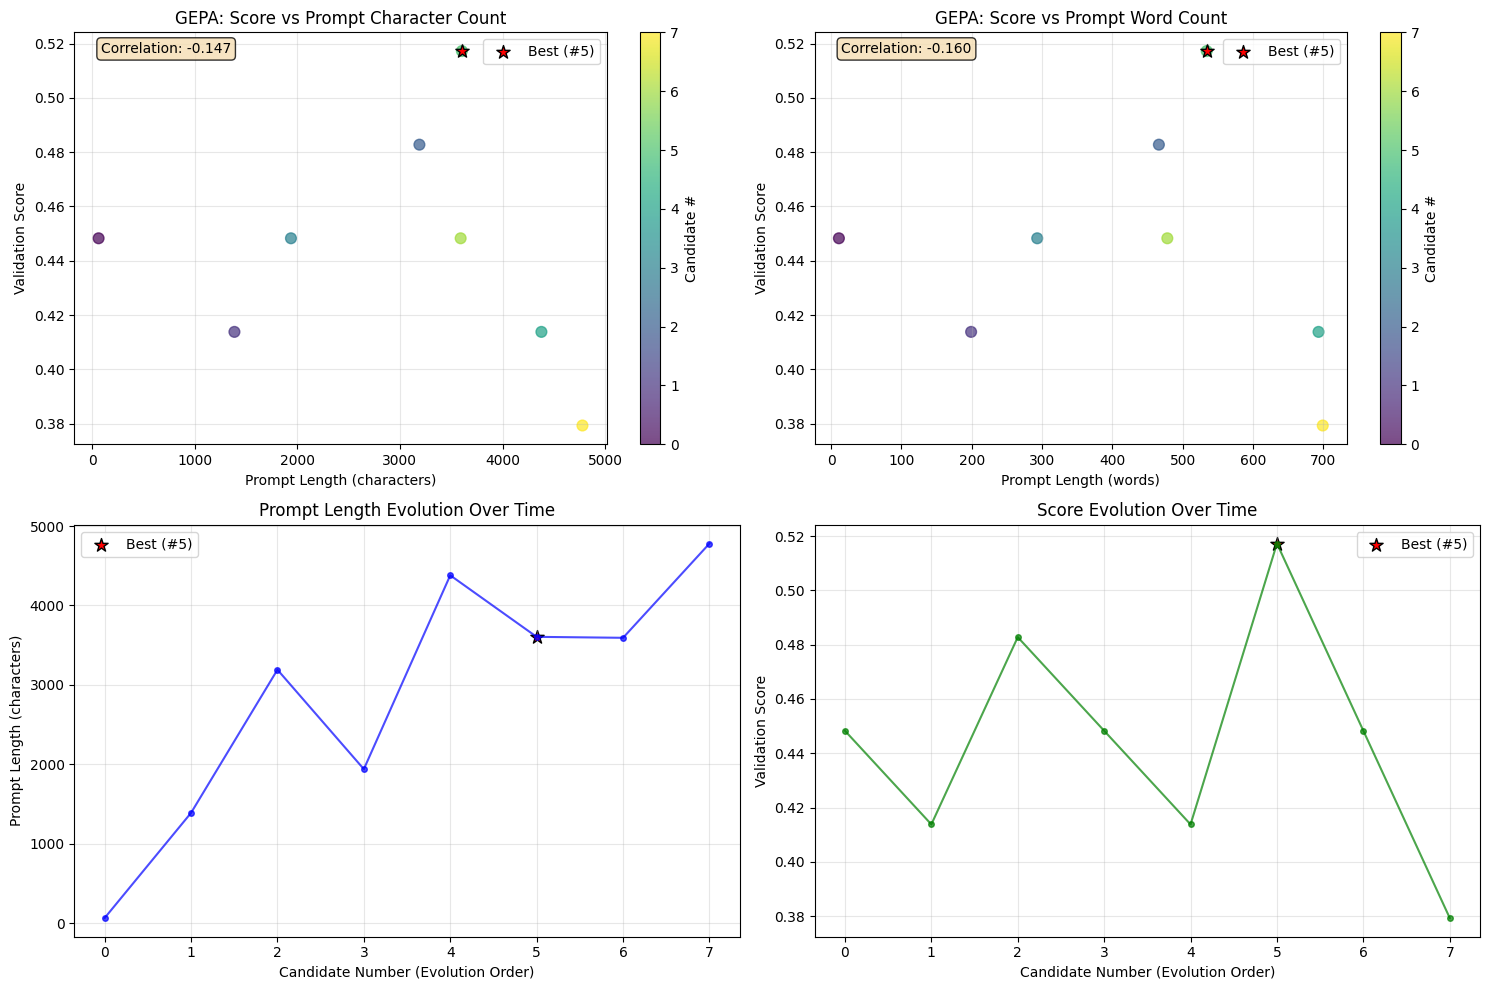


GEPA PROMPT EVOLUTION ANALYSIS

Prompt Length Statistics:
Character count range: 63 - 4779 chars
Word count range: 11 - 699 words
Average character count: 2866.5 chars
Average word count: 421.6 words

Score Statistics:
Score range: 0.3793 - 0.5172
Average score: 0.4440
Score std dev: 0.0402

Best Candidate:
Candidate #5: Score=0.5172
Length: 3604 chars, 534 words

Correlations:
Length (chars) vs Score: -0.147
Length (words) vs Score: -0.160

Evolution Summary:
Character growth: 63 → 4779 (+4716 chars, +7485.7%)
Score change: 0.4483 → 0.3793 (-0.0690)


In [25]:
# After running GEPA with track_stats=True
if hasattr(optimized_program, 'detailed_results'):
    results = optimized_program.detailed_results
    
    # Extract data for plotting
    prompt_chars = []
    prompt_words = []
    scores = []
    candidate_nums = []
    
    for i, (candidate, score) in enumerate(zip(results.candidates, results.val_aggregate_scores)):
        for name, predictor in candidate.named_predictors():
            prompt = predictor.signature.instructions
            prompt_chars.append(len(prompt))
            prompt_words.append(len(prompt.split()))
            scores.append(score)
            candidate_nums.append(i)
            break  # Just take first predictor
    
    # Create the plots
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Score vs Character Count
    scatter1 = ax1.scatter(prompt_chars, scores, c=candidate_nums, cmap='viridis', alpha=0.7, s=60)
    ax1.set_xlabel('Prompt Length (characters)')
    ax1.set_ylabel('Validation Score')
    ax1.set_title('GEPA: Score vs Prompt Character Count')
    ax1.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    if len(prompt_chars) > 1:
        correlation_chars = np.corrcoef(prompt_chars, scores)[0, 1]
        ax1.text(0.05, 0.95, f'Correlation: {correlation_chars:.3f}', 
                transform=ax1.transAxes, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Add best candidate annotation
    best_idx = results.best_idx
    best_char_count = prompt_chars[best_idx]
    best_score = scores[best_idx]
    ax1.scatter([best_char_count], [best_score], c='red', s=100, marker='*', 
               label=f'Best (#{best_idx})', edgecolor='black', linewidth=1)
    ax1.legend()
    
    # Plot 2: Score vs Word Count
    scatter2 = ax2.scatter(prompt_words, scores, c=candidate_nums, cmap='viridis', alpha=0.7, s=60)
    ax2.set_xlabel('Prompt Length (words)')
    ax2.set_ylabel('Validation Score')
    ax2.set_title('GEPA: Score vs Prompt Word Count')
    ax2.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    if len(prompt_words) > 1:
        correlation_words = np.corrcoef(prompt_words, scores)[0, 1]
        ax2.text(0.05, 0.95, f'Correlation: {correlation_words:.3f}', 
                transform=ax2.transAxes, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Add best candidate annotation
    best_word_count = prompt_words[best_idx]
    ax2.scatter([best_word_count], [best_score], c='red', s=100, marker='*', 
               label=f'Best (#{best_idx})', edgecolor='black', linewidth=1)
    ax2.legend()
    
    # Plot 3: Evolution Timeline - Character Count
    ax3.plot(candidate_nums, prompt_chars, 'b-o', markersize=4, alpha=0.7)
    ax3.scatter([best_idx], [best_char_count], c='red', s=100, marker='*', 
               label=f'Best (#{best_idx})', edgecolor='black', linewidth=1)
    ax3.set_xlabel('Candidate Number (Evolution Order)')
    ax3.set_ylabel('Prompt Length (characters)')
    ax3.set_title('Prompt Length Evolution Over Time')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot 4: Evolution Timeline - Scores
    ax4.plot(candidate_nums, scores, 'g-o', markersize=4, alpha=0.7)
    ax4.scatter([best_idx], [best_score], c='red', s=100, marker='*', 
               label=f'Best (#{best_idx})', edgecolor='black', linewidth=1)
    ax4.set_xlabel('Candidate Number (Evolution Order)')
    ax4.set_ylabel('Validation Score')
    ax4.set_title('Score Evolution Over Time')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Add colorbar for candidate numbers
    plt.colorbar(scatter1, ax=ax1, label='Candidate #')
    plt.colorbar(scatter2, ax=ax2, label='Candidate #')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("GEPA PROMPT EVOLUTION ANALYSIS")
    print("="*60)
    
    print(f"\nPrompt Length Statistics:")
    print(f"Character count range: {min(prompt_chars)} - {max(prompt_chars)} chars")
    print(f"Word count range: {min(prompt_words)} - {max(prompt_words)} words")
    print(f"Average character count: {np.mean(prompt_chars):.1f} chars")
    print(f"Average word count: {np.mean(prompt_words):.1f} words")
    
    print(f"\nScore Statistics:")
    print(f"Score range: {min(scores):.4f} - {max(scores):.4f}")
    print(f"Average score: {np.mean(scores):.4f}")
    print(f"Score std dev: {np.std(scores):.4f}")
    
    print(f"\nBest Candidate:")
    print(f"Candidate #{best_idx}: Score={best_score:.4f}")
    print(f"Length: {best_char_count} chars, {best_word_count} words")
    
    if len(prompt_chars) > 1:
        print(f"\nCorrelations:")
        print(f"Length (chars) vs Score: {correlation_chars:.3f}")
        print(f"Length (words) vs Score: {correlation_words:.3f}")
        
        # Growth analysis
        initial_chars = prompt_chars[0]
        final_chars = prompt_chars[-1]
        char_growth = final_chars - initial_chars
        char_growth_pct = (char_growth / initial_chars * 100) if initial_chars > 0 else 0
        
        initial_score = scores[0]
        final_score = scores[-1]
        score_change = final_score - initial_score
        
        print(f"\nEvolution Summary:")
        print(f"Character growth: {initial_chars} → {final_chars} ({char_growth:+d} chars, {char_growth_pct:+.1f}%)")
        print(f"Score change: {initial_score:.4f} → {final_score:.4f} ({score_change:+.4f})")
else:
    print("No detailed results found. Make sure to run GEPA with track_stats=True")